In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt

from model import lorenz63_fdm, M63
from assimilation import OI, ExtendedKF, M3DVar, EnKF, Hybrid3DEnVar

In [2]:
def RMSE(forecast, nature):
    return np.sqrt(np.mean((forecast-nature)**2, axis=0))

In [3]:
X_nature = np.load('./data/X_nature.npy')
X_ini = np.load('./data/X_ini.npy')
ts = np.load('./data/time_span.npy')
Pb = np.load('./data/Pb.npy')
R = np.load('./data/R.npy')
obs = np.load('./data/obs_normal.npy')

dt = 0.01
obs_intv = 8

# generate initial ensemble
N_ens = 30
rng = np.random.RandomState(42)
X_ens_ini = rng.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (3, N_ens)

## Assimilate full normal obs

In [4]:
params = {
    'X_ens_ini': X_ens_ini, 
    'obs': obs,
    'obs_interv': obs_intv, 
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.3,
    'inflat': 1.4
}
enkf = EnKF(lorenz63_fdm, dt)
enkf.set_params(**params)
enkf.cycle()

0.894119936134673


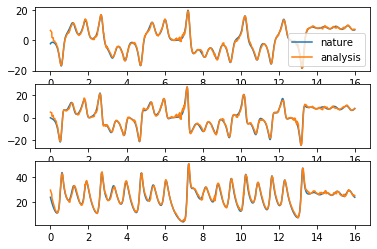

In [5]:
ensmean = enkf.analysis.mean(axis=0)

fig, axs = plt.subplots(nrows=3)
for i in range(3):
    axs[i].plot(ts, X_nature[i,:], label='nature')
    axs[i].plot(ts, ensmean[i,:], label='analysis')
axs[0].legend()

print(RMSE(ensmean, X_nature).mean())

## Assimilate normal obs

### x only

In [6]:
params = {
    'X_ens_ini': X_ens_ini, 
    'obs': obs[[0],:],
    'obs_interv': obs_intv, 
    'R': np.array([[2]]),
    'H_func': lambda arr: arr[[0]],
    'alpha': 0.3,
    'inflat': 1.4
}
enkf = EnKF(lorenz63_fdm, dt)
enkf.set_params(**params)
enkf.cycle()

2.1768803942626147


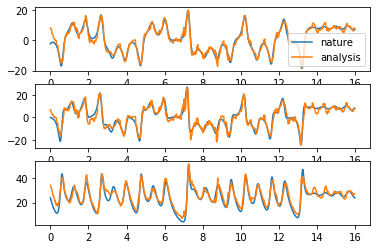

In [7]:
ensmean = enkf.analysis.mean(axis=0)

fig, axs = plt.subplots(nrows=3)
for i in range(3):
    axs[i].plot(ts, X_nature[i,:], label='nature')
    axs[i].plot(ts, ensmean[i,:], label='analysis')
axs[0].legend()

print(RMSE(ensmean, X_nature).mean())

### y only

In [8]:
params = {
    'X_ens_ini': X_ens_ini, 
    'obs': obs[[1],:],
    'obs_interv': obs_intv, 
    'R': np.array([[2]]),
    'H_func': lambda arr: arr[[1]],
    'alpha': 0.3,
    'inflat': 1.4
}
enkf = EnKF(lorenz63_fdm, dt)
enkf.set_params(**params)
enkf.cycle()

1.5225290945804613


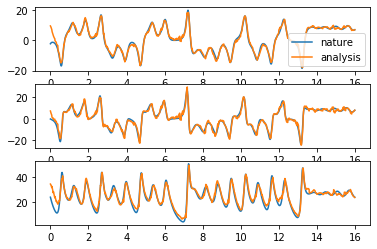

In [9]:
ensmean = enkf.analysis.mean(axis=0)

fig, axs = plt.subplots(nrows=3)
for i in range(3):
    axs[i].plot(ts, X_nature[i,:], label='nature')
    axs[i].plot(ts, ensmean[i,:], label='analysis')
axs[0].legend()

print(RMSE(ensmean, X_nature).mean())

### z only

In [10]:
params = {
    'X_ens_ini': X_ens_ini, 
    'obs': obs[[2],:],
    'obs_interv': obs_intv, 
    'R': np.array([[2]]),
    'H_func': lambda arr: arr[[2]],
    'alpha': 0.3,
    'inflat': 1.1
}
enkf = EnKF(lorenz63_fdm, dt)
enkf.set_params(**params)
enkf.cycle()

8.123616515452657


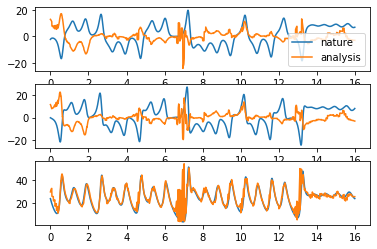

In [11]:
ensmean = enkf.analysis.mean(axis=0)

fig, axs = plt.subplots(nrows=3)
for i in range(3):
    axs[i].plot(ts, X_nature[i,:], label='nature')
    axs[i].plot(ts, ensmean[i,:], label='analysis')
axs[0].legend()

print(RMSE(ensmean, X_nature).mean())

In [12]:
## 只同化 Z 的情況下，維持和前面一樣的參數會 overflow
## 所以之後就不看 Z 的情況了

## Assimilate skew obs

### x

In [13]:
path = './repeat_experiments_partial/X'
da_schemes = ['enkf', '3dvar']
repeat_times = 10
alphas = [1.30, 1.55, 1.80, 2.05, 2.30, 2.55, 2.80, 3.05, 3.30]
rmse_da_dict = {}

for da_s in da_schemes:
    # 10 -> repeat experiments for 10 times
    rmse_alpha = []
    
    for alpha in alphas:
        rmsemean_list = []
        for t in range(repeat_times):
            fn = f'{path}/{da_s}_analysis_alpha{alpha*100:03.0f}_t{t}.npy'
            analysis = np.load(fn)

            if da_s == 'enkf':
                # ensemble mean
                analysis = analysis.mean(axis=0)

            rmse = RMSE(analysis, X_nature)
            rmse_mean = rmse.mean()
            rmsemean_list.append(rmse_mean)
            
        rmse_alpha.append(rmsemean_list)
        
    rmse_da_dict[da_s] = np.array(rmse_alpha)

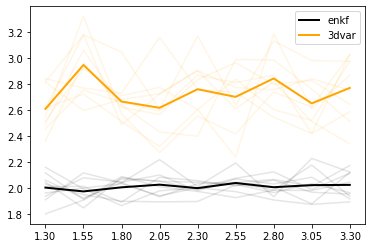

In [14]:
colors = ['black', 'orange']

for (da_s, val), color in zip(rmse_da_dict.items(), colors):
    for itimes in range(repeat_times):
        plt.plot(alphas, val[:,itimes], c=color, alpha=0.1)
    plt.plot(alphas, val.mean(axis=1), c=color, lw=2, label=da_s)
plt.legend()
plt.xticks(alphas);

### Y

In [15]:
path = './repeat_experiments_partial/Y'
da_schemes = ['enkf', '3dvar']
repeat_times = 10
alphas = [1.30, 1.55, 1.80, 2.05, 2.30, 2.55, 2.80, 3.05, 3.30]
rmse_da_dict = {}

for da_s in da_schemes:
    # 10 -> repeat experiments for 10 times
    rmse_alpha = []
    
    for alpha in alphas:
        rmsemean_list = []
        for t in range(repeat_times):
            fn = f'{path}/{da_s}_analysis_alpha{alpha*100:03.0f}_t{t}.npy'
            analysis = np.load(fn)

            if da_s == 'enkf':
                # ensemble mean
                analysis = analysis.mean(axis=0)

            rmse = RMSE(analysis, X_nature)
            rmse_mean = rmse.mean()
            rmsemean_list.append(rmse_mean)
            
        rmse_alpha.append(rmsemean_list)
        
    rmse_da_dict[da_s] = np.array(rmse_alpha)

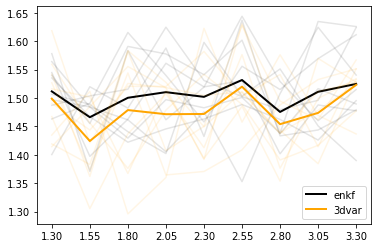

In [16]:
colors = ['black', 'orange']

for (da_s, val), color in zip(rmse_da_dict.items(), colors):
    for itimes in range(repeat_times):
        plt.plot(alphas, val[:,itimes], c=color, alpha=0.1)
    plt.plot(alphas, val.mean(axis=1), c=color, lw=2, label=da_s)
plt.legend()
plt.xticks(alphas);